In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Activation, Dropout,Conv2D, MaxPooling2D,BatchNormalization,Flatten
from keras.optimizers import Adam,Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,load_model,Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
from IPython.display import display,HTML

(534, 962, 4)


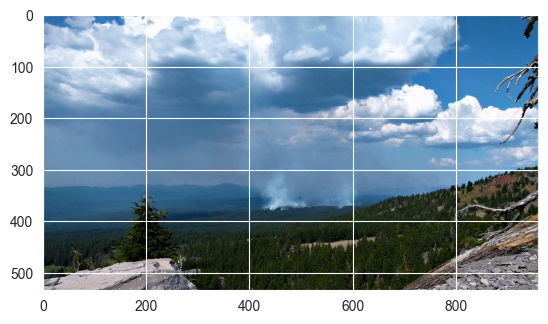

In [3]:
imgpath ='C:/Users/sanat/Downloads/smokefire/train-smoke/10.png'
img=plt.imread(imgpath)
print(img.shape)
imshow(img)

In [6]:
filepaths=[]
labels=[]
smoke='C:/Users/sanat/Downloads/smokefire/train-smoke'
fire='C:/Users/sanat/Downloads/smokefire/train_fire'
for d in [smoke,fire]:
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)
        if d==smoke:
            labels.append('smoke')
        else:
            labels.append('fire')
print('filepaths: ',len(filepaths),' labels: ',len(labels))

filepaths:  13733  labels:  13733


In [7]:
Fseries=pd.Series(filepaths,name='filepaths')
Lseries=pd.Series(labels,name='labels')
df=pd.concat([Fseries,Lseries],axis=1)
print(df.head())
print(df.tail())
vcounts=df['labels'].value_counts()
print(vcounts)
vcounts=list(vcounts)
vmin=np.min(vcounts)
classes=df['labels'].unique()
print(classes)
class_count=len(classes)

                                           filepaths labels
0  C:/Users/sanat/Downloads/smokefire/train-smoke...  smoke
1  C:/Users/sanat/Downloads/smokefire/train-smoke...  smoke
2  C:/Users/sanat/Downloads/smokefire/train-smoke...  smoke
3  C:/Users/sanat/Downloads/smokefire/train-smoke...  smoke
4  C:/Users/sanat/Downloads/smokefire/train-smoke...  smoke
                                               filepaths labels
13728  C:/Users/sanat/Downloads/smokefire/train_fire\...   fire
13729  C:/Users/sanat/Downloads/smokefire/train_fire\...   fire
13730  C:/Users/sanat/Downloads/smokefire/train_fire\...   fire
13731  C:/Users/sanat/Downloads/smokefire/train_fire\...   fire
13732  C:/Users/sanat/Downloads/smokefire/train_fire\...   fire
labels
smoke    12631
fire      1102
Name: count, dtype: int64
['smoke' 'fire']


In [9]:
file_count=1102
samples=[]
for category in df['labels'].unique():
    category_slice=df.query('labels==@category')
    samples.append(category_slice.sample(file_count,replace=False,random_state=1))
df=pd.concat(samples,axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)
print(df['labels'].value_counts())
print(len(df))

labels
fire     1102
smoke    1102
Name: count, dtype: int64
2204


In [ ]:
height=200
width=400
channels=3
batch_size=80
img_shape=(height,width,channels)
img_size=(height,width)
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df,dummy_df=train_test_split(df,train_size=train_split,shuffle=True,random_state=123)
test_df,valid_df=train_test_split(dummy_df,train_size=dummy_split,shuffle=True,random_state=123)
print('train samples: ',len(train_df),'test samples: ',len(test_df),'validation samples: ',len(valid_df))
len(valid_df)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length%n==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print('test batch size: ',test_batch_size,' test steps: ',test_steps)
def scalar(img):
    return img/127.5 - 1
trgen=ImageDataGenerator(preprocessing_function=scalar,horizontal_flip=True,vertical_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
 